In [3]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=6000)])  # limit to 6GB
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
import os
import numpy as np
import nibabel as nib
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import ndimage
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split


In [4]:
#specify the directory
base_dir = '/Tensorflow_Vision/3D_CNN/CT_Scans'
no_pneumonia = os.path.join(base_dir, 'no_viral_pneumonia')
with_pneumonia = os.path.join(base_dir, 'with_viral_pneumonia')

In [5]:
#check the number of CT Scans with normal lung tissue
normal_scan_paths = [os.path.join(no_pneumonia, i) for i in os.listdir(no_pneumonia)]
print(f'Number of CT Scans with normal lung tissue: {len(normal_scan_paths)}')

#check the number of CT Scans with abnormal lung tissue
abnormal_scan_paths = [os.path.join(with_pneumonia, i) for i in os.listdir(with_pneumonia)]
print(f'Number of CT Scans with normal lung tissue: {len(abnormal_scan_paths)}')

Number of CT Scans with normal lung tissue: 100
Number of CT Scans with normal lung tissue: 100


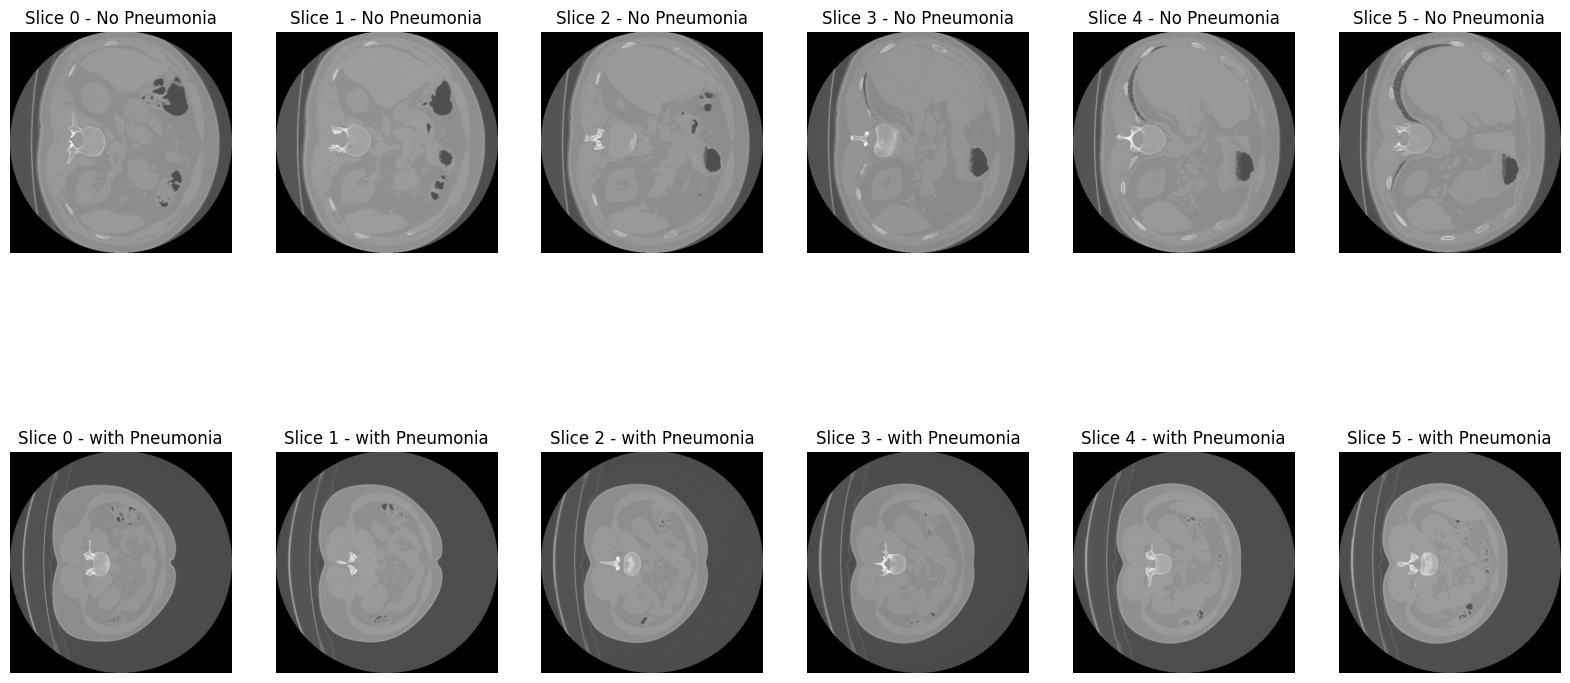

In [6]:
#Load sample image with Pneumonia
img_with_pneumonia = nib.load(abnormal_scan_paths[0])
img_array_with_pneumonia = img_with_pneumonia.get_fdata()

#Load sample image without Pneumonia
img_without_pneumonia = nib.load(normal_scan_paths[0])
img_array_without_pneumonia = img_without_pneumonia.get_fdata()

#plot the slices of the CT Scan images with and without Pneumonia
plt.figure(figsize=(20, 10))
for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.imshow(img_array_without_pneumonia[:, :, i], cmap='gray')
    plt.title('Slice {} - No Pneumonia'.format(i))
    plt.axis('off')

    plt.subplot(2, 6, 6 + i + 1)
    plt.imshow(img_array_with_pneumonia[:, :, i], cmap='gray')
    plt.title('Slice {} - with Pneumonia'.format(i))
    plt.axis('off')
plt.show()

Preprocessing

In [7]:
def read_nifti_file(file_path):
    """Read and Load volume"""
    scan = nib.load(file_path)
    scan = scan.get_fdata()
    return scan

In [8]:
#check actual image shape
file_path = '/Tensorflow_Vision/3D_CNN/CT_Scans/no_viral_pneumonia/study_0002.nii.gz'
scan = read_nifti_file(file_path)
print(scan.shape)

(512, 512, 42)


In [9]:
from skimage.transform import resize

def resize_and_normalize_volume(img):
    desired_shape = (150, 150, 32)

    # Resize using skimage.resize for exact shape
    img_resized = resize(img, desired_shape, mode='constant', anti_aliasing=True)

    # Normalize HU window [-1000, 400]
    min_HU = -1000
    max_HU = 400
    img_resized = np.clip(img_resized, min_HU, max_HU)
    img_normalized = (img_resized - min_HU) / (max_HU - min_HU)

    # Add channel dimension
    img = img_normalized[..., np.newaxis]  

    return img

In [10]:
processed_abnormal = []
for i, p in enumerate(abnormal_scan_paths):
    vol = read_nifti_file(p)
    vol = resize_and_normalize_volume(vol)
    if i < 2:  # print only for the first 2
        print(vol.shape)
    processed_abnormal.append(vol)
abnormal_scans = np.array(processed_abnormal)

processed_normal = []
for i, p in enumerate(normal_scan_paths):
    vol = read_nifti_file(p)
    vol = resize_and_normalize_volume(vol)
    if i < 2:  # print only for the first 2
        print(vol.shape)
    processed_normal.append(vol)
normal_scans = np.array(processed_normal)

(150, 150, 32, 1)
(150, 150, 32, 1)
(150, 150, 32, 1)
(150, 150, 32, 1)


In [11]:
# for viral pneumonia assign 1
# for normal assign 0
abnormal_labels = np.ones(len(abnormal_scans))
normal_labels = np.zeros(len(normal_scans))

**Splitting Data**

In [ ]:
# Combine abnormal and normal scans
x = np.concatenate((abnormal_scans, normal_scans), axis=0)  # shape should be (N, W, H, D, 1) ideally

# Make sure data has 5 dimensions: (N, W, H, D, 1)
x = np.squeeze(x, axis=-1)  
if len(x.shape) == 4:        
    x = np.expand_dims(x, axis=-1)  

# Combine labels
y = np.concatenate((abnormal_labels, normal_labels), axis=0)

#  convert data to float32 to reduce memory 
x = x.astype('float32')

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

print(f"Number of Samples in Train and Validation sets are {x_train.shape[0]} and {x_val.shape[0]}")

Number of Samples in Train and Validation sets are 170 and 30


In [ ]:
print("x shape:", x.shape)

In [ ]:
print("Total samples:", len(y))
print("Label counts:", np.unique(y, return_counts=True))

**Data Pre-processing and Augmentation**

In [ ]:
#data augmentation
#@tf.function
def augment_volume(volume):
    def scipy_augment(volume_np):
        angles = [-50, -20, -10, -5, 5, 10, 20, 50]
        angle = random.choice(angles)
        volume_np = ndimage.rotate(volume_np, angle, reshape=False)

        # Random flip along axes: 0, 1, 2 (width, height, depth)
        for axis in range(3):
            if random.random() > 0.5:  # 50% chance to flip along this axis
                volume_np = np.flip(volume_np, axis=axis)

        # Clamp values to [0, 1]
        volume_np = np.clip(volume_np, 0, 1)

        return volume_np.astype(np.float32)

    augmented_volume = tf.numpy_function(scipy_augment, [volume], tf.float32)
    # Set shape to allow TF to infer shape 
    augmented_volume.set_shape(volume.shape)
    return augmented_volume

def train_preprocessing(volume, label):
    """Preprocess the training data by augmenting and adding a channel"""
    volume = augment_volume(volume)  
    volume = tf.expand_dims(volume, axis=-1)  
    return volume, label

def validation_preprocessing(volume, label):
    """Preprocess the validation data by only adding a channel"""
    #volume = tf.expand_dims(volume, axis=3)  
    return volume, label

# Define the data loader
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))
batch_size = 2
# Augment during training
train_dataset = (
    train_loader.shuffle(buffer_size=2)
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(buffer_size=2)
)
# Rescale only
validation_dataset =(
    validation_loader.shuffle(buffer_size=2)
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(buffer_size=2)
)

**Visualizing an Augmented CT Scan**

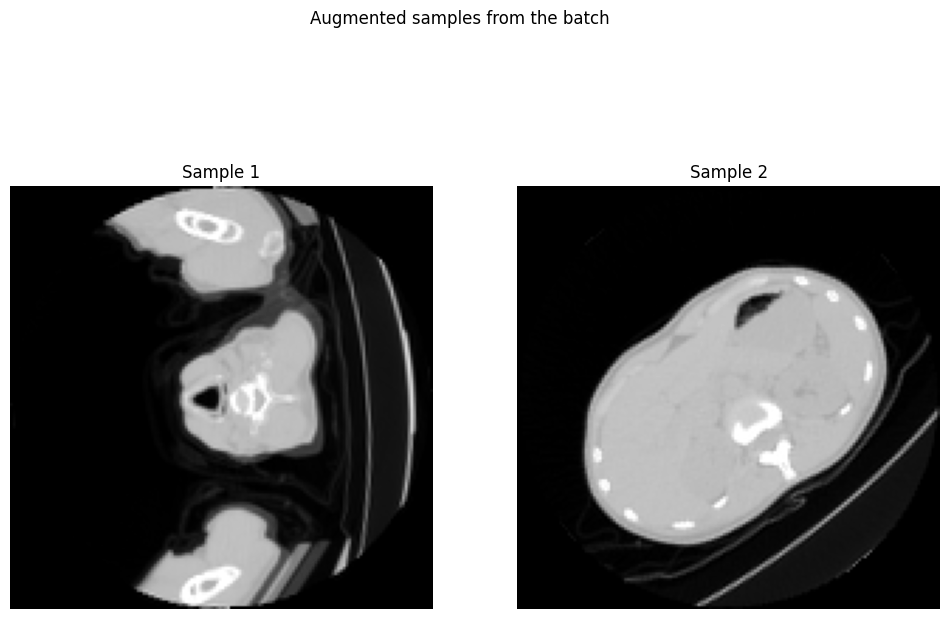

In [ ]:
# Get a single batch from the dataset

for images, labels in train_dataset.take(1):
    images = tf.cast(images, tf.float32).numpy()  # Convert to float32 for plotting
    batch_size = images.shape[0]  

    fig, axs = plt.subplots(1, batch_size, figsize=(12, 8))

    for i in range(batch_size):
        axs[i].imshow(images[i, :, :, 31, 0], cmap='gray')
        axs[i].set_title(f"Sample {i+1}")
        axs[i].axis('off')

    plt.suptitle("Augmented samples from the batch")
    plt.show()

**Build The Model under GPU Capacity**

In [16]:
from tensorflow.keras import layers, regularizers


def improved_3d_cnn(input_shape=(150, 150, 32, 1)):
    l2 = regularizers.l2(1e-4)
    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv3D(32, (3,3,3), padding='same', kernel_regularizer=l2)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

    # Block 2
    x = layers.Conv3D(64, (3,3,3), padding='same', kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

    # Block 3
    x = layers.Conv3D(128, (3,3,3), padding='same', kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

    # Block 4 - for deeper features
    x = layers.Conv3D(256, (3,3,3), padding='same', kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.GlobalAveragePooling3D()(x)

    # Dense layers
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2)(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=l2)(x)

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

# Build the model
model = improved_3d_cnn()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 32, 1   0         
                             )]                                  
                                                                 
 conv3d_4 (Conv3D)           (None, 150, 150, 32, 32   896       
                             )                                   
                                                                 
 batch_normalization_4 (Bat  (None, 150, 150, 32, 32   128       
 chNormalization)            )                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 150, 150, 32, 32   0         
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 75, 75, 16, 32)    0   

**Visual Representation of 3D CNN**

In [ ]:
#Display the Model architecture
#plot_model(model, to_file='3D_CNN_CTscan.jpg')

**Model Compile**

In [17]:
#model compile
initial_learning_rate = 0.00001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                          decay_steps= 1500,
                                                          decay_rate= 0.96, staircase=True) #discrete state update lr

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics = ["acc"],)

In [10]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

**Callbacks and Save Weights**

In [11]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("/Tensorflow_Vision/3D_CNN/ct_weights_150_150_32_Adam.keras", save_best_only=True)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(
    log_dir=log_dir, 
    histogram_freq=1, 
    write_graph=True, 
    update_freq='epoch'
)


In [12]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 44138), started 0:00:56 ago. (Use '!kill 44138' to kill it.)

**Train the Model**

In [ ]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(x_train))  # shuffle all samples
train_dataset = train_dataset.batch(batch_size)                  # batch samples
train_dataset = train_dataset.repeat()                           # repeat indefinitely for .fit
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  # use autotuner for memory/perf

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = validation_dataset.batch(batch_size)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Train the model
model.fit(
    train_dataset,
    epochs=150,
    steps_per_epoch=len(x_train) // batch_size,   
    validation_data=validation_dataset,
    validation_steps=len(x_val) // batch_size,    
    callbacks=[checkpoint_cb, tensorboard_cb],
    verbose=2,
    shuffle=False  # already shuffled in dataset pipeline
)

Epoch 1/150


2025-08-07 22:23:09.159202: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8901
2025-08-07 22:23:13.021799: I external/local_xla/xla/service/service.cc:168] XLA service 0x707124c4f910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-07 22:23:13.021857: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-08-07 22:23:13.057714: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754598193.226493   95768 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 - 31s - loss: 0.8402 - acc: 0.5059 - val_loss: 0.7503 - val_acc: 0.5000 - 31s/epoch - 364ms/step
Epoch 2/150
85/85 - 7s - loss: 0.8116 - acc: 0.5000 - val_loss: 0.7492 - val_acc: 0.5000 - 7s/epoch - 79ms/step
Epoch 3/150
85/85 - 7s - loss: 0.7779 - acc: 0.5235 - val_loss: 0.7506 - val_acc: 0.5000 - 7s/epoch - 77ms/step
Epoch 4/150
85/85 - 6s - loss: 0.7645 - acc: 0.5176 - val_loss: 0.7671 - val_acc: 0.5000 - 6s/epoch - 76ms/step
Epoch 5/150
85/85 - 6s - loss: 0.7518 - acc: 0.5529 - val_loss: 0.7826 - val_acc: 0.5000 - 6s/epoch - 76ms/step
Epoch 6/150
85/85 - 6s - loss: 0.7379 - acc: 0.5765 - val_loss: 0.7858 - val_acc: 0.5000 - 6s/epoch - 75ms/step
Epoch 7/150
85/85 - 7s - loss: 0.7222 - acc: 0.6059 - val_loss: 0.7437 - val_acc: 0.5333 - 7s/epoch - 79ms/step
Epoch 8/150
85/85 - 7s - loss: 0.7428 - acc: 0.5765 - val_loss: 0.6964 - val_acc: 0.6333 - 7s/epoch - 77ms/step
Epoch 9/150
85/85 - 7s - loss: 0.7458 - acc: 0.6059 - val_loss: 0.6793 - val_acc: 0.7000 - 7s/epoch - 77ms/step
E

**Load Trained Model and Prediction**

In [6]:
model = tf.keras.models.load_model("/Tensorflow_Vision/3D_CNN/ct_weights_150_150_32_Adam.keras")

2025-08-07 23:03:17.521031: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8901


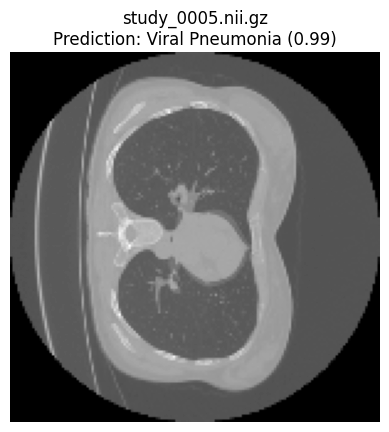

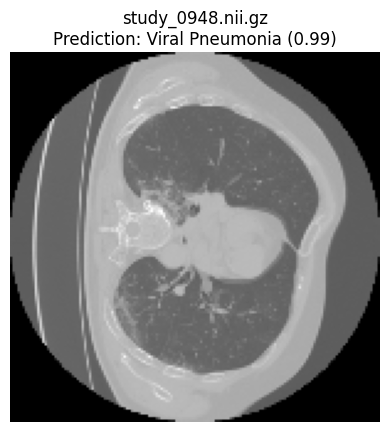

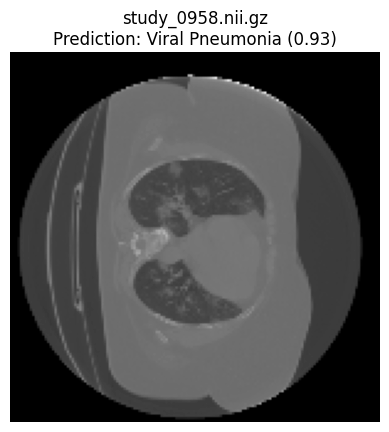

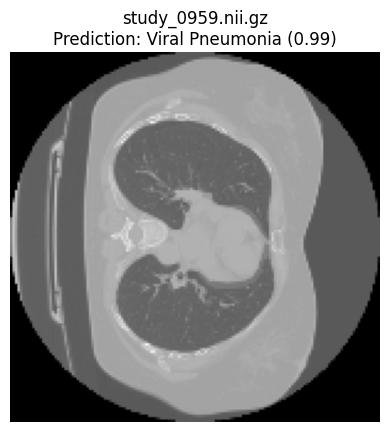

In [ ]:
label_names = {0: "Normal", 1: "Viral Pneumonia"}

def load_scan(path):
    """Load and preprocess the 3D scan to shape (150, 150, 32)"""
    scan = nib.load(path).get_fdata()
    scan = scan.astype(np.float32)

    # Normalize to [0, 1]
    scan = (scan - np.min(scan)) / (np.max(scan) - np.min(scan) + 1e-5)

    # Resize to (150, 150, 32)
    scan_resized = tf.image.resize(scan, [150, 150])  # Resize H x W for each depth slice
    scan_resized = tf.transpose(scan_resized, [2, 0, 1])  # D x H x W
    scan_resized = tf.image.resize(scan_resized, [32, 150])  # Resize depth to 32
    scan_resized = tf.transpose(scan_resized, [1, 2, 0])  # Back to H x W x D

    return scan_resized.numpy()

def predict_scan(model, scan):
    """Expand dims and run prediction"""
    scan = np.expand_dims(scan, axis=0)      # (1, 128, 128, 32)
    scan = np.expand_dims(scan, axis=-1)     # (1, 128, 128, 32, 1)

    preds = model.predict(scan, verbose=0)[0]

    if preds.shape == (1,):  # Binary classification
        pred_class = int(preds[0] > 0.5)
        confidence = float(preds[0])
    else:  # Multi-class (not used here but safe check)
        pred_class = int(np.argmax(preds))
        confidence = float(preds[pred_class])
    
    return pred_class, confidence

def display_scan_prediction(scan, filename, pred_class, confidence):
    """Show middle slice and prediction result"""
    label = label_names[pred_class]
    mid_slice = scan[:, :, scan.shape[2] // 2]
    plt.imshow(mid_slice, cmap="gray")
    plt.title(f"{filename}\nPrediction: {label} ({confidence:.2f})")
    plt.axis("off")
    plt.show()

# === Run prediction on all files from the folder ===

prediction_dir = "/Tensorflow_Vision/3D_CNN/prediction"

if not os.path.exists(prediction_dir):
    raise FileNotFoundError(f"Prediction folder not found: {prediction_dir}")

# List all scan paths
prediction_scan_paths = [
    os.path.join(prediction_dir, f)
    for f in os.listdir(prediction_dir)
    if f.endswith(".nii") or f.endswith(".nii.gz")
]

if not prediction_scan_paths:
    print("No .nii or .nii.gz files found in the prediction folder.")

# Run predictions and display
for path in prediction_scan_paths:
    try:
        scan = load_scan(path)
        pred_class, conf = predict_scan(model, scan)
        filename = os.path.basename(path)
        display_scan_prediction(scan, filename, pred_class, conf)
    except Exception as e:
        print(f"Error processing {path}: {e}")